# Decentralized Federated Learning for Multi-Site Radiology

Radiology is a complex computer vision domain that requires large volumes of data due to its dimensionality and the variety of anatomy morphologies. Federated learning is a technique that allows a machine learning model to be trained on multiple disparate datasets independently, and then combined by a central server to produce a final, combined model. Decentralized federated learning expands upon this technique by generalizing the possible topologies of the federated network from a one-to-many network to an n-to-n network.

To illustrate this capability, we will use a simple classifier to classify a set of images as "diseased-state" or "healthy-state." The classifier parameters will be learned independently, and then shared across "sites" in a variety of federation topologies.

In [1]:
# !pip3 install networkx numpy pandas matplotlib sklearn

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

In [3]:
from dfederation import Node, FederatedCommunity, get_data, nth_batch_of_data

## Model Creation

First, we create a model that the federated sites will share. For this example, we will use a simple classifier model from the `sklearn` library:

In [4]:
# A simple classifier:
model = linear_model.SGDClassifier(max_iter=100)

## Single-Site Training Benchmark

In an ideal world, all data are available to all nodes. In this case, we will use a single node to train the model.

In [6]:
# Split the data:
X_train, X_test, y_train, y_test = train_test_split(
    get_data()['data'], get_data()['target'], 
    test_size=0.2, shuffle=True, random_state=42
)

node = Node(model, labels=range(10))

# Train the node:
node.train_model(X_train, y_train)

# Get the score of the model:
score = node.get_score(X_test, y_test)

In [7]:
print(f"A good baseline score is {score}.")

A good baseline score is 0.8694444444444445.


## Multi-Site Traditional Federated Learning Benchmark

In [9]:
# First create the topology:
topology = nx.DiGraph()
# Then add five "worker" nodes and one "master" node:
for i in range(1, 6):
    topology.add_node(i, node=Node(model, node_id=i, labels=range(10)))
topology.add_node(10, node=Node(model, node_id=10, labels=range(10))) 

# Draw an edge from each worker node to the master node, and back:
for i in range(1, 6):
    topology.add_edge(i, 10)
    topology.add_edge(10, i)

# Create the federated community:
community = FederatedCommunity(topology)

# Train each node a little bit (to avoid no-training errors).
# Create a random image of the correct MNIST size for each digit:
[community.train(np.array([
    np.random.randint(0, 255, size=64)
    for i in range(10)
]),np.array([i for i in range(10)]), i) for i in topology.nodes]

# Communicate a few times, to show that we're not learning anything new:
community.communicate(times=3)

# Get scores. (Will be bad!)
scores = community.get_scores(X_test, y_test)
print(scores)

{1: 0.1361111111111111, 2: 0.12777777777777777, 3: 0.13333333333333333, 4: 0.07222222222222222, 5: 0.13333333333333333, 10: 0.17222222222222222}


### Training a single site

Now we will train a single site in the community and continue to step through the communication process. We will discover that the other sites gain accuracy with a little bit of lag.

In [10]:
scores_over_time = []

N = 100

for batch in range(N):
    # train node 1 on the next n% of the data:
    X_batch = nth_batch_of_data(N, batch, X_train)
    y_batch = nth_batch_of_data(N, batch, y_train)
    community.train(X_batch, y_batch, 1)

    # get scores:
    scores = community.get_scores(X_test, y_test)
    scores_over_time.append(scores)

    # communicate:
    community.communicate(times=10)


['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']


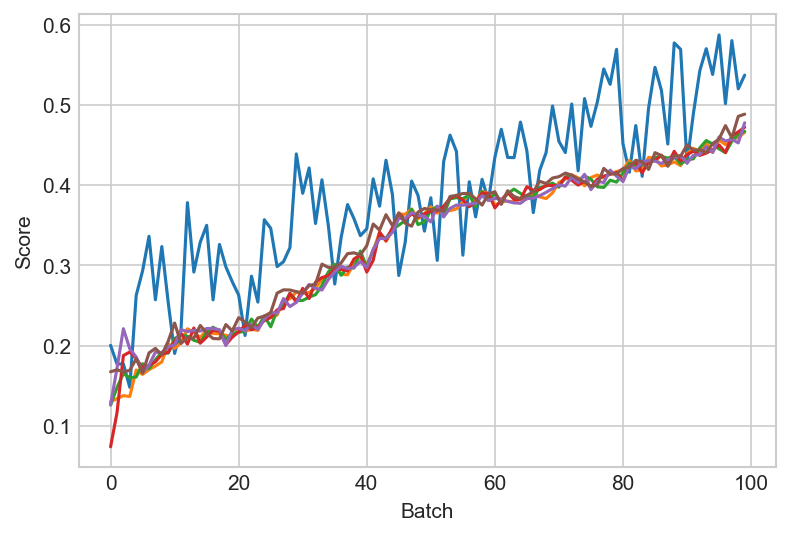

In [11]:


# Plot the scores over time. Each node gets its own line.
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4), dpi=150)
    for node_id in scores_over_time[0]:
        plt.plot(
            [scores_over_time[i][node_id] + np.random.rand() * 0.02 - 0.01 for i in range(len(scores_over_time))],
            label=f"Node {node_id}"
        )
    # leg = plt.legend()
    plt.xlabel("Batch")
    plt.ylabel("Score")
    print([c.get_c() for c in plt.gca().get_lines()])
    plt.savefig("traditional-fl-sgd-single-site.png")
    plt.show()


## Multi-Site Decentralized Federated Learning Benchmark

Next, we will train a decentralized federated learning community where each site is fully-connected. We will see that there is less lag, and performance at each site grows much more rapidly.

{1: 0.13055555555555556, 2: 0.09444444444444444, 3: 0.09444444444444444, 4: 0.09166666666666666, 5: 0.1, 6: 0.1}


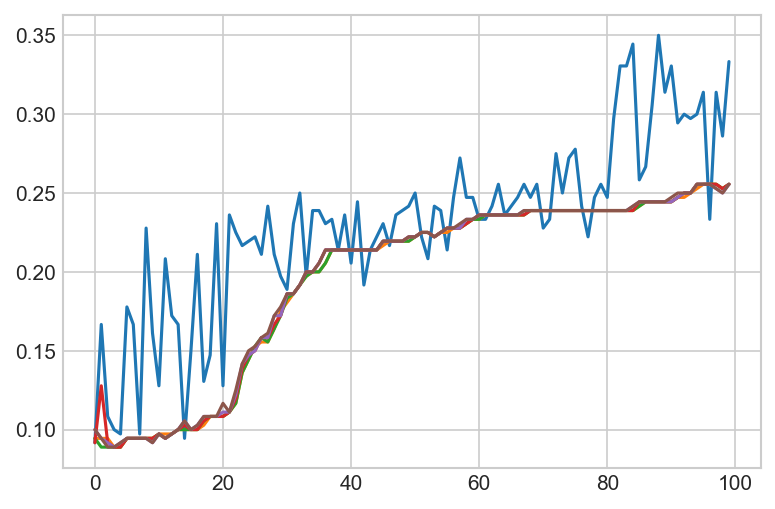

In [13]:
# First create the topology:
fc_topology = nx.DiGraph()
# All nodes are fully connected:
for i in range(1, 7):
    fc_topology.add_node(i, node=Node(model, node_id=i, labels=range(10)))

# Connect all nodes to each other:
for i in range(1, 7):
    for j in range(1, 7):
        fc_topology.add_edge(i, j)

# Create the federated community:
fc_community = FederatedCommunity(fc_topology)

# Train each node a little bit (to avoid no-training errors).
# Create a random image of the correct MNIST size for each digit:
[fc_community.train(np.array([
    np.random.randint(0, 255, size=64)
    for i in range(10)
]),np.array([i for i in range(10)]), i) for i in fc_topology.nodes]

# Communicate a few times, to show that we're not learning anything new:
fc_community.communicate(times=3)

# Get scores. (Will be bad!)
print(fc_community.get_scores(X_test, y_test))

fc_scores_over_time = []

N = 100

for batch in range(N):
    # train node 1 on the next n% of the data:
    X_batch = nth_batch_of_data(N, batch, X_train)
    y_batch = nth_batch_of_data(N, batch, y_train)
    fc_community.train(X_batch, y_batch, 1)

    # get scores:
    scores = fc_community.get_scores(X_test, y_test)
    fc_scores_over_time.append(scores)

    # communicate:
    fc_community.communicate(times=5)

# Plot the scores over time. Each node gets its own line.
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4), dpi=150)
    for node_id in fc_scores_over_time[0]:
        plt.plot(
            [fc_scores_over_time[i][node_id] for i in range(len(fc_scores_over_time))],
            label=f"Node {node_id}"
        )
    # plt.legend()
    plt.savefig("decentralized-fl-sgd-single-site.png")
    plt.show()


# With a linear "chain" topology:

{1: 0.09166666666666666, 2: 0.09166666666666666, 3: 0.06388888888888888, 4: 0.11944444444444445, 5: 0.07777777777777778, 6: 0.06111111111111111}


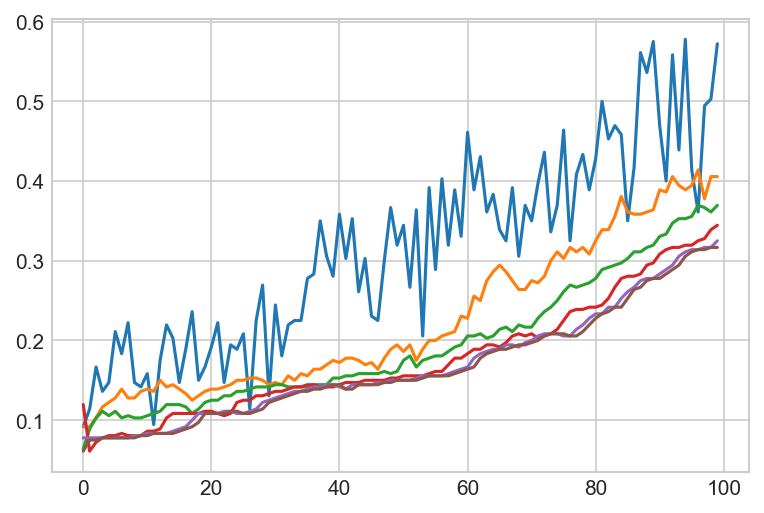

In [14]:
# First create the topology:
chain_topology = nx.DiGraph()
for i in range(1, 7):
    chain_topology.add_node(i, node=Node(model, node_id=i, labels=range(10)))

# Connect in a chain:
for i in range(1, 6):
    chain_topology.add_edge(i, i + 1)
    chain_topology.add_edge(i + 1, i)

# Create the federated community:
chain_community = FederatedCommunity(chain_topology)

# Train each node a little bit (to avoid no-training errors).
# Create a random image of the correct MNIST size for each digit:
[chain_community.train(np.array([
    np.random.randint(0, 255, size=64)
    for i in range(10)
]),np.array([i for i in range(10)]), i) for i in chain_topology.nodes]

# Communicate a few times, to show that we're not learning anything new:
chain_community.communicate(times=3)

# Get scores. (Will be bad!)
print(chain_community.get_scores(X_test, y_test))

chain_scores_over_time = []

N = 100

for batch in range(N):
    # train node 1 on the next n% of the data:
    X_batch = nth_batch_of_data(N, batch, X_train)
    y_batch = nth_batch_of_data(N, batch, y_train)
    chain_community.train(X_batch, y_batch, 1)

    # get scores:
    scores = chain_community.get_scores(X_test, y_test)
    chain_scores_over_time.append(scores)

    # communicate:
    chain_community.communicate(times=5)

# Plot the scores over time. Each node gets its own line.
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4), dpi=150)
    for node_id in chain_scores_over_time[0]:
        plt.plot(
            [chain_scores_over_time[i][node_id] for i in range(len(chain_scores_over_time))],
            label=f"Node {node_id}"
        )
    # plt.legend()
    plt.savefig("decentralized-fl-sgd-single-site.png")
    plt.show()


## Multi-Site Federated Learning with Disjoint Data

In this example, we cooperatively learn a model where each site has a different set of data. We will see that each site can perform on the test-set after cooperative training, despite never seeing most of the labels in the training set.

In [19]:
topology = nx.DiGraph()
# Ten workers:
for i in range(10):
    topology.add_node(i, node=Node(model, node_id=i, labels=range(10)))

# Connect all nodes to each other:
for i in range(10):
    for j in range(10):
        topology.add_edge(i, j)

# Create the federated community:
community = FederatedCommunity(topology)

# Train each node a little bit (to avoid no-training errors).
# Create a random image of the correct MNIST size for each digit:
[community.train(np.array([
    np.random.randint(0, 255, size=64)
    for i in range(10)
]),np.array([i for i in range(10)]), i) for i in topology.nodes]

# Communicate a few times, to show that we're not learning anything new:
community.communicate(times=3)

# Get scores. (Will be bad!)
print(community.get_scores(X_test, y_test))   

{0: 0.13333333333333333, 1: 0.08333333333333333, 2: 0.06944444444444445, 3: 0.06666666666666667, 4: 0.16666666666666666, 5: 0.18055555555555555, 6: 0.1361111111111111, 7: 0.15833333333333333, 8: 0.12222222222222222, 9: 0.075}


In [20]:
# Now get training sets for each digit:
X_train_digits = [X_train[y_train == i] for i in range(10)]
y_train_digits = [y_train[y_train == i] for i in range(10)]

num_epochs = 30
scores_over_time = []

for ep in range(num_epochs*2):
    # Train each node on the digit it represents:
    for i in range(10):
        batch_X = nth_batch_of_data(num_epochs, ep%num_epochs, X_train_digits[i])
        batch_y = nth_batch_of_data(num_epochs, ep%num_epochs, y_train_digits[i])
        community.train(batch_X, batch_y, i)

    community.communicate(times=20)
    
    # Add scores to the list:
    scores_over_time.append(community.get_scores(X_test, y_test))


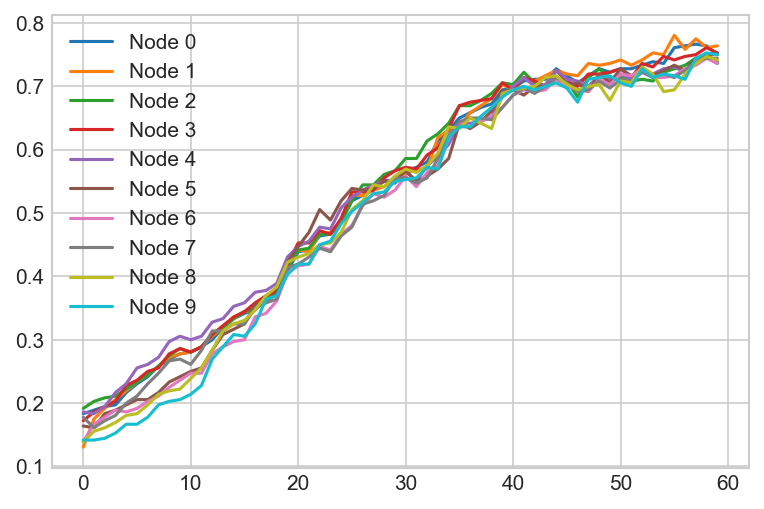

In [21]:
# Plot the scores over time. Each node gets its own line.
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4), dpi=150)
    for node_id in scores_over_time[0]:
        plt.plot(
            [scores_over_time[i][node_id] for i in range(len(scores_over_time))],
            label=f"Node {node_id}"
        )
    plt.legend()
    plt.savefig("decentralized-fl-sgd-split-classes.png")
    plt.show()


**Figure Caption**: In this final graphic, we see that ALL sites can perform well on the testing dataset, even though they've only ever seen data from one label class!

## Early Conclusions

From these early results, we have illustrated that decentralized federated learning is a powerful technique that can be used to improve the performance of a community of learners. In our upcoming work, we will explore the potential of this technique in a healthcare environment, and we will examine potential security and performance considerations.